In [1]:
!nvidia-smi

Thu Apr 27 17:44:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.4 MB/s eta 0:00:00


In [3]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install livelossplot --quiet
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

In [5]:
import transformers

from torch.utils.data import Dataset
import json

from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader
import tqdm
import torch

In [6]:
print(transformers.__version__)
print(torch.__version__)

4.28.1
2.0.0+cu118


In [7]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

device

'cuda'

# Define our Dataset class.

In [9]:
class ASCIIDataset(Dataset):
    def __init__(self, path, tokenizer):
        '''
            Path: string of the path to the raw data to convert to a dataset.

                The path should a contain a file formatted as an array of JSON objects where the object is of the form:
                    {
                        "prompt": "...",
                        "text": "..."
                    }

            Tokenizer:

                The tokenizer used on the prompts and responses of the dataset. Should be GPT2 pre-trained tokenizer.
        '''
        self.data = None
        self.X = []
        self.tokenizer = tokenizer
        # ID OF THE TOKEN USED TO INDICATE WHEN A RESPONSE BEGINS
        self.res_id = 50260 # = self.decode_str("<RES>:")


        with open(path, 'r') as file:
            self.data = json.load(file)

            for entry in self.data:
                prompt = entry['prompt']
                text = entry['text']
                self.X.append(f'<BOS> {prompt}\n\n<RES>:\n\n{text}\n\n<EOS>')

        print(f"Number of Samples in Dataset: {len(self.X)}")


        



        print("Tokenizing Text...")
        # self.X_encoded = self.tokenizer(self.X, max_length=1024, truncation=True, padding="max_length", return_tensors="pt")
        self.X_encoded = self.tokenizer(self.X, padding=True, truncation=True, return_tensors="pt")
        # self.X_encoded = self.tokenizer(self.X, truncation=True, return_tensors="pt")

        print("Done Tokenizing.")
        self.input_ids = self.X_encoded['input_ids']
        print(self.input_ids.size())
        self.attention_mask = self.X_encoded['attention_mask']


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.input_ids[idx], self.attention_mask[idx])

    def decode(self, tokens):
        return self.tokenizer.decode(tokens)
    
    def decode_token(self, token_id):
        return self.tokenizer.decoder.get(token_id)
    
    def decode_str(self, word):
        return self.tokenizer.get_vocab()[word]

## Instantiate our Tokenizer, model, dataset, and optimizer

In [10]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({"pad_token": "<pad>", 
                                "bos_token": "<BOS>",
                                "eos_token": "<EOS>"})
tokenizer.add_tokens(["<RES>:"])

model = GPT2LMHeadModel.from_pretrained("gpt2-medium")


# optim = Adam(model.parameters())



In [11]:
model.resize_token_embeddings(len(tokenizer))

Embedding(50261, 1024)

In [12]:
ASCII_DATA = ASCIIDataset("./raw_data_subset2.json", tokenizer)

Number of Samples in Dataset: 3
Tokenizing Text...
Done Tokenizing.
torch.Size([3, 831])


In [13]:
len(ASCII_DATA)
ASCII_DATA.decode(ASCII_DATA[0][0])

'<BOS> Please generate ASCII art of an emoji of grinning face <RES>: %?????******?????%                    \n                S???*****++;;;;;;++*****???S               \n             S???**++;::............::;;+**???%            \n          ???**+;::.....................:;+**???          \n        ???**+::::::::..............::::::::;**???        \n       %??**+;:::::::::::::::::::::::::::::::::;**??S      \n     ???*+;::::::::::::::::::::::::::::::::::;:;+*???     \n    ??**+;;;;;;;;;;;::::::::::::::::::;;;;;;;;;;;+*???    \n    %??*+;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;+*??%   \n   S??**+++++;;;;;;*%SS%+;;;;;;;;;;*%SS%+;;;;;;++++++*???  \n  ???*++++++++++;*#SSS#%+;;;;;;;;*##SS#S++++++++++++*??%  \n  *%??**++++++++++*#SSSS%++++++++;*SSSSSS+++++++++++**??%? \n ????***++++++++++*%%%%+++++++++++*%%%%*++++++++++***??%% \n  %%??****+++++++++++++++++++++++++++++++++++++++++***??%% \n  %%??***+++++++++++++++++++++++++++++++++++++++++****??%% \n ?%???***+*?**+++++++++++++++++++++++++++++

In [14]:
def pretty_print(text):
    lines = text.split("\n")
    for line in lines:
        print(line)

In [16]:
t = ASCII_DATA.decode(ASCII_DATA[1][0])

pretty_print(t)
# t

<BOS> Please generate ASCII art of an emoji of smirking face <RES>: %?????******?????%                    
                S???****+++;;;;;;+++***????S               
             %???**+;;::............::;;+**???%            
          ???**+;::.....................:;+**???          
         %??**+::::::::.............:::::::::;+*??%        
       #??**+;:::::::::::::::::::::::::::::::::;**??S      
     ???*+;::::::::::::::::::::::::::::::::::;;;+*??%     
    ???*+;;;;;;;;;;;;:::::::::::::::;;;;;;;;;;;;;+*???    
   ???*++;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;+;+*???   
  ???**+++*?%%%%%*+;;;;;;;;;;;;;;;;;;;;+?%%%%%?*++++*???  
  ???*++?SS%?***?%%+;;;;;;;;;;;;;;;;;;+%%?***?%SS?++*??%  
 ????**SS*++++++++++++++++++++++++++++++++++++++*SS**??%* 
 ???**%%++++++++++++++++++++++++++++++++++++++++++%S**??? 
 ?%??****++++++******+++++++++++++++++++******+++++**??%% 
 ?%??****+*?%SS###SS#S*++++++++++++*?%SS##SS#S%*+****??%% 
 ?%??****+*%%???%SSSS#?++++++++++++?%????%SSSS#*+****??%? 
 ?%%

In [ ]:
# for token in ASCII_DATA[10][0]:
#     print("Token: ", tokenizer.decode(token))

In [ ]:
# from collections import defaultdict
# dic = defaultdict(int)
# for token in ASCII_DATA[0][0]:
#     dic[tokenizer.decode(token)] += 1
# # print(dic)
# # print(max(dic, key= lambda x: dic[x]))
# freq = dict(dic)
# max(freq, key=freq.get)
# freq[" "]

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

354827264

In [ ]:
print(ASCII_DATA[0][0].size())

# for _ in (ASCII_DATA[0][1]):
#     print(_)
ASCII_DATA.decode_str("<RES>:")
# ASCII_DATA[0]['input_ids'].size()
# for _ in range(5):
#     print(ASCII_DATA[_][0][:10])
#     print(ASCII_DATA[_][1][:20])
#     print("\n\n\n")

torch.Size([817])


50260

In [17]:
dataloader = DataLoader(ASCII_DATA, batch_size=1, shuffle=True) # can be changed to the number of available cores

In [18]:
loss_logs = open("loss_logs2.txt","w+")

In [19]:
def train(model, optimizer, dataloader, epochs):
 
    liveloss = PlotLosses(outputs=[MatplotlibPlot(figpath ="./pdf_plot2.pdf")])

    model.train()
    n_batches = len(dataloader)
    # training loop
    for _ in tqdm.tqdm(range(epochs)):

        logs = {}
        cum_loss = 0

        for i, (b_ids, b_masks) in enumerate(dataloader):

            model.zero_grad(set_to_none=True)
            
            b_ids = b_ids.to(device)
            b_masks = b_masks.to(device)
            b_labels = b_ids

            # optim.zero_grad()

            out = model(input_ids=b_ids, 
                         labels=b_labels,
                         attention_mask=b_masks)
            
            loss = out.loss
            # print(loss)

            cum_loss += loss.item()

            loss.backward()
            optim.step()

        # Plot average loss every 10 epochs
        if _ % 10 == 0:
            # print(f"Epoch: {_}")
            # print(f'Epoch: {i} --- Current loss: {loss}')
            logs['loss'] = cum_loss / n_batches
            loss_logs.write(f"EPOCH [{_}] LOSS [{cum_loss / n_batches}]\n")
            # update plot w/ losses 
            liveloss.update(logs)
            liveloss.send()


    # save model parameters after training
    torch.save(model.state_dict(), f"model_state_subset.pt")
    # close log file
    loss_logs.close()

In [20]:
model = model.to(device)
model.train()

# BATCH_SIZE = 16
# EPOCHS = 5
LEARNING_RATE = 3e-5
# WARMUP_STEPS = 5000
# MAX_SEQ_LEN = 1024

optim = AdamW(model.parameters(), lr=LEARNING_RATE)


In [21]:
!nvidia-smi

Thu Apr 27 17:47:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    42W / 300W |   2222MiB / 16384MiB |     29%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

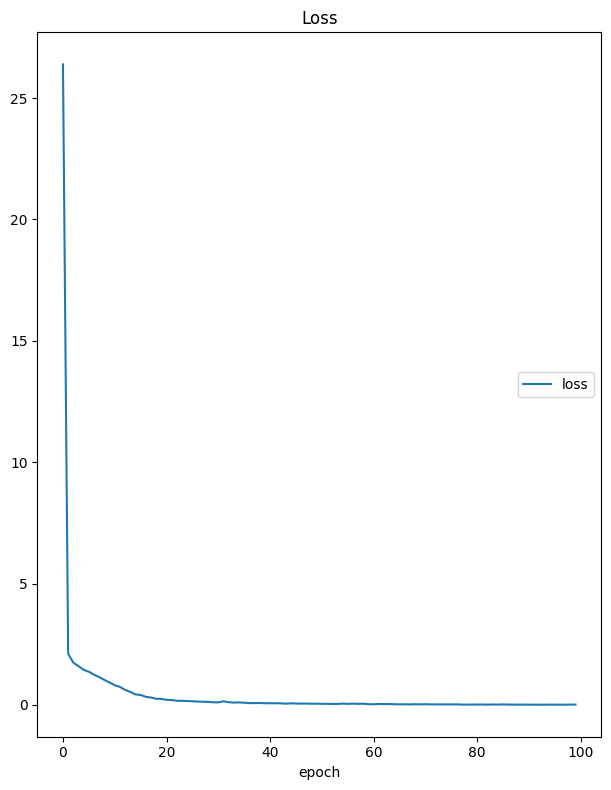

100%|██████████| 1000/1000 [13:28<00:00,  1.24it/s]


In [22]:
# Train on each sample image 1000 x


train(model, optim, dataloader, 1000)

In [26]:
# Ground Truth:
print(ASCII_DATA.decode(ASCII_DATA[2][0]))


<BOS> Please generate ASCII art of an emoji of face with rolling eyes <RES>: %??????****???????S                   
                S???****+++;;;;;;+++****???%               
             %???**++;::............::;;+**???%            
           %??**+;:......................:;+**???          
        ???**+:::::::...............::::::::;+*??%        
       %??**+::::::::::::::::::::::::::::::::::;**???      
     ???*+;::::::::::::::::::::::::::::::::::;:;+*??%     
    ???*+;;;;;;;;;:::::::::::::::::::;::;;;;;;;;;+*???    
    %??*+;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;+*??%   
  ????*+++++**?S#S%**+;;;;;;;;;;;;;;+**?S#S%**++++++*???  
   %??*+++*?*+*@   ?;*?*+;;;;;;;;;*?*;*@   @?+*?*+++*??%  
 ?%??*++*?+:.+@    +..;**++++++;+**;:.+@   @+..+??++*??%? 
 ???****?;....;*?*;....;**++++++**;....:*?*;....;?****??? 
 ?%??**?*:..............+?++++++*+:..............*?**??%% 
  %%??**?*:..............+*++++++*+:.............:*?**??%% 
 ?%??***?+:............;**++++++**;.............;?**

In [24]:
def prompt(model, prompt):

    # prompt = json_input['prompt']
    # text = ""
    # inp = f'<BOS> {prompt}\n<RES>:\n{tbext}\n<EOS>'
    inp = f'<BOS> {prompt}\n\n<RES>:\n\n'
    print(inp)
    # inp = tokenizer(inp, return_tensors="pt")
    inp = tokenizer(inp, truncation=True, padding=True, return_tensors="pt")
    # inp = tokenizer(prompt, return_tensors='pt')
    # print(inp.size())
    x = inp["input_ids"].to(device)
    a = inp["attention_mask"].to(device)
    # print(a)

    # res_i = (x == 50260).nonzero(as_tuple=True)[0]
    # a[res_i + 1:] = 0

    pad_token = ASCII_DATA.decode_str("<pad>")
    # eos_token = ASCII_DATA.decode_str("<pad>")

    output = model.generate(x, max_length=1024)
    # output = model.generate(x, attention_mask=a, pad_token_id=pad_token, max_length=1024)
    output = tokenizer.decode(output[0])
    return output

In [ ]:
# Generated response:
prompt(model, 'Please generate ASCII art of an emoji of grinning face')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<BOS> Please generate ASCII art of an emoji of grinning face

<RES>:




'<BOS> Please generate ASCII art of an emoji of grinning face <RES>: %?????******                                                               S???*****++                              S???**++                          S??**+**+                             S??**+ Metronome+                    S???**+ Scorecard???**+                  S??**+::::::::..............#??++                 S??**-ores??*+;+ores??*+;+ores??*+;+s??*+;+s??S#??++++;;+        S??**+++++;+S;;+;+S??S#??S#??+++++;+S??S#??++++;+       S??**+++++++++;**??*+;+S??S#??S+++++++++;+         S??**+++++++++;**??*+;+S??S+++++++++++++;+          S??**+++++++++;**??*-?*+;S??S#??S#??%??+;+            S??**+++++++++;**?*?**?*+;?S??S#??%??+++++++++;+             S??**++++++++++;**??%??*++++++++++;+                                 %??**%S;;;+S%??S#??S#??+++++;+                           %??**%SS%??*++;;??S#SSSSSS%??*+;+                                %??**%SSSS%??*+;?%%%%%%%%%S#SSSS%??*+                                       %??**%SSS

In [29]:
res = prompt(model, 'Please generate ASCII art of an emoji with rolling eyes and a smirking face')

pretty_print(res)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<BOS> Please generate ASCII art of an emoji with rolling eyes and a smirking face

<RES>:


<BOS> Please generate ASCII art of an emoji with rolling eyes and a smirking face <RES>: %??????****???????S                        
                  S???****+++;;;;;;+++****???%                 
             %???**++;::............::;;+**???%              
           %??**+;:......................:;+**???           
         ???**+:::::::...............::::::::;+*??%         
        %??**+::::::::::::::::::::::::::::::::::::::::::;**???      
    ???*+;::::::::::::::::::::::::::::::::::;:;+*??%     
   ???*+;;;;;;;;;:::::::::::::::::::;::;;;;;;;;;+*???    
    %??*+;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;+*??%   
  ????*+++++**?S#S%**+;;;;;;;;;;;;;;+**?S#S%**++++++*???  
   %??*+++*?*+*@   ?;*?*+;;;;;;;;;*?*;*@   @?+*?*+++*??%  
 ?%??*++*?+:.+@    +..;**++++++;+**;:.+@   @+..+??++*??%? 
 ???****?;....;*?*;....;**++++++**;....:*?*;....;?****??? 
 ?%??**?*:..............+?++++++*+:...........

In [ ]:
res = prompt(model, 'Please generate ASCII art of an emoji of grinning face with raised')

pretty_print(res)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<BOS> Please generate ASCII art of an emoji of grinning face with raised

<RES>:


<BOS> Please generate ASCII art of an emoji of grinning face with raised <RES>: ing eyebrow <RES>: %?????*??????%                   
                 ????*******+********????                
               S??****+;;:::......:::;;++**???S             
           ???**+;::...................:;+**???           
         ???*+;::....................:;;;::;+*???         
       ???*+;:::::::::::::::::::::;*?SSSSS%+:;+*???       
      ??**+;::::::::::::::::::::*SSS?+;;;;*%+::;**??%     
     S??**;;;;;;:::::::::::::::::;+;::::::::;;;;;;+*??%    
   ???*+;;;;;;+*%%%?*+;;;;;;;;;;;:;;;;;;;;;;;;;;;;+*??%   
   ??**++++;;?SS%??%SSSSS%+;;;;;;;;;*??*;;;;;;;;+++**??   
   %??**+++++++++;;;;++++***;;;;;;;;+%####?+;+++++++++*??%  
 ????*+++++++++++%S##S%+;;;;;+;;+;*#SSSSS*++++++++++**??? 
 ????**+++++++++%#SSSS#?++++++++++*SSSSSS*+++++++++***??? 
 ????***++++++++*%SSSS%*+++++++++++?SSSS?+++++++++***??? 
  %%??****++++

In [ ]:
test_model = GPT2LMHeadModel.from_pretrained("gpt2-medium")
test_model.resize_token_embeddings(len(tokenizer))

# new_model = models.vgg16() # we do not specify weights, i.e. create untrained model
test_model.load_state_dict(torch.load('./model_state_0.pt'))
test_model.to(device)
test_model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50261, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50261, bias=False)
)

In [ ]:
res = prompt(test_model, 'Please generate ASCII art of an emoji of grinning face')

pretty_print(res)

Keyword arguments {'max_new_tokens': 1024} not recognized.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<BOS> Please generate ASCII art of an emoji of grinning face

<RES>:


<BOS> Please generate ASCII art of an emoji of grinning face <RES>: Sending emoji of smiling face

 <pad> Sending emoji of smiling face
 <pad> S <pad> S

Sending emoji of smiling face

Sending emoji of smiling face
 <pad> S
 <pad> S
 <pad> S

Sending emoji of smiling face

Sending emoji of smiling face
 <pad> S

Sending emoji of smiling face

Sending emoji of smiling face

S <pad> S

S

S
 <BOS> S
 <pad> S

S

S

S

S

S

S

S
 <BOS> S
 <pad> S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S

S
 <pad> <pad> <pad> <pad> 

S
 <pad> S
 <pad> S

S

S

S

S

S

S
 <pad> S
 <pad> S
 <pad> S

S

S

S

S

S
 <pad> S
 <pad> S

S
 <BOS> S

S

S

S

S

S

S
 <pad> S

S
 <pad> S
 <pad> S

S

S

S

S

S
 <pad> S
 <pad> S
 <pad> S

S

S

S
 <pad> S
 <pad> S
 <pad> S
 <pad> S
 <pad> S

S

S

S

S

S

S
 <BOS> S

S
 <pad> S
 <pad> S
 <pad> S
 <BOS> S

S

S

S

S



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!cp -r "./model_state_subset.pt" "/content/drive/MyDrive"

In [ ]:
from numba import cuda
# all of your code and execution
cuda.select_device(0)
# cuda.close()

KeyboardInterrupt: ignored

In [ ]:
device = cuda.get_current_device() 
# device.reset()